In [1]:
#  _____  _       _ _                                       
# |  __ \(_)     (_) |                                      
# | |  | |_  __ _ _| |_                                     
# | |  | | |/ _` | | __|                                    
# | |__| | | (_| | | |_                                
# |_____/|_|\__, |_|\__|_  __ _           _   _             
#      | |   __/ |     (_)/ _(_)         | | (_)            
#   ___| | _|___/__ ___ _| |_ _  ___ __ _| |_ _  ___  _ __  
#  / __| |/ _` / __/ __| |  _| |/ __/ _` | __| |/ _ \| '_ \ 
# | (__| | (_| \__ \__ \ | | | | (_| (_| | |_| | (_) | | | |
#  \___|_|\__,_|___/___/_|_| |_|\___\__,_|\__|_|\___/|_| |_| v0.9 (not yet v1.0, lab task: make it version 1.0!)
#                                                           
#  Lab I for the course Applied Machine Learning DT4031, Halmstad University
#  Author: "Dr. Datas Ciense", "The Random-ML Company"
#
#  Instruction to you:
#      * TODO 1: I've been working on this code for digit classification, could you please tell me which is the best type of classifier of the two provided?
#      * TODO 2: I'm trying to visualize the input representation in two dimensions. Run the code to see the figure. How would you interpret the scatter plot? (in relation to the course video lectures)
#      * TODO 3: I have another idea of feature extraction, how about we just compute the mean (and standard deviation) in intensity in X and Y directions?
#        Such that we will have four (two for mean and two for std) additional vectors as features (each with length 28).
#        If you write a function able to compute such features, and use these features in training together with the HOG features,
#        would it lead to better generaliztion (improved accuracy)? Don't forget to normalize these new feature vectors also.
#      * TODO 4: Which digit(s) seems to be the most difficult to predict using the k-NN classifier? Could you use the confusion matrix functions:
#        "plot_confusion_matrix" and visualize and draw conclusions and present to me? (you might have to read up into the literature about confusion matrices)
#      * TODO 5 (optional): I'm using 3 neighbours for k-NN, how about we use 5 or 7 neighbours?
#        Would this lead to a better generalization performance? Could you test this? (if so, think about training, validation and test set split)
#
#      When all these steps are done we could release this code as v1.0.
#

In [2]:
# Perform necessary imports for the analysis tasks
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from skimage.feature import hog
from random import randrange
import scipy.stats as stats
import pandas as pd
import numpy as np
import gzip
import os
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score


In [3]:
# Use dark mode of the matplotlib
# plt.style.use('dark_background')

<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


### 1. Downloading the MNIST dataset

In [4]:
# Correct base URL for downloading the MNIST dataset files
#base_url = "https://github.com/fgnt/mnist/raw/master/"
#dataset_files = [
#    "train-images-idx3-ubyte.gz",
#    "train-labels-idx1-ubyte.gz",
#    "t10k-images-idx3-ubyte.gz",
#    "t10k-labels-idx1-ubyte.gz"
#]

# Function to download the files
#for file_name in dataset_files:
#    file_url = base_url + file_name
#    if not os.path.isfile(file_name):
#        print(f"Downloading {file_name}...")
#        try:
#            response = requests.get(file_url, allow_redirects=True)
#            if response.status_code == 200:
#                with open(file_name, 'wb') as f:
#                    f.write(response.content)
#                print(f"Downloaded {file_name}.")
#            else:
#                print(f"Failed to download {file_name}: HTTP {response.status_code}")
#        except Exception as e:
#            print(f"Error downloading {file_name}: {e}")
#    else:
#        print(f"Skipping {file_name}, already downloaded.")


<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


### 2 + 5. Reading the dataset into memory and train/test split



In [5]:
# Function for reading input images
def read_idx3_ubyte_data(filename: str, image_size: int = 28):
    

    f = gzip.open(filename,'r')
    
    f.seek(0, os.SEEK_END)
    num_images = int(f.tell()/(image_size*image_size))
    f.seek(0, 0)
    print("Reading %d number of images" % num_images)
    
    f.read(16)
    buf = f.read(image_size * image_size * num_images)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    data = data.reshape(num_images, image_size, image_size, 1)
    
    return data

# Function for reading labels
def read_labels_data(filename: str):
    labels = []
    f = gzip.open(filename,'r')
    
    f.seek(0, os.SEEK_END)
    num_labels = f.tell()-8
    f.seek(0, 0)
    print("Reading %d number of labels" % num_labels)
    f.read(8)
    for i in range(0, num_labels):
        buf = f.read(1)
        label = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        labels.append(label)
    
    return labels


In [6]:
# read data (both images and correspondig labels)
data_train = read_idx3_ubyte_data('train-images-idx3-ubyte.gz')
data_test = read_idx3_ubyte_data('t10k-images-idx3-ubyte.gz')
labels_train = read_labels_data('train-labels-idx1-ubyte.gz')
labels_test = read_labels_data('t10k-labels-idx1-ubyte.gz')

Reading 60000 number of images
Reading 10000 number of images
Reading 60000 number of labels
Reading 10000 number of labels


<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


### 3. Plotting an example digit

In [7]:
def plot_single_digit(digit_data):    
    image = np.asarray(digit_data).squeeze()
    plt.imshow(image, cmap='gray')
    plt.colorbar()
    plt.show()

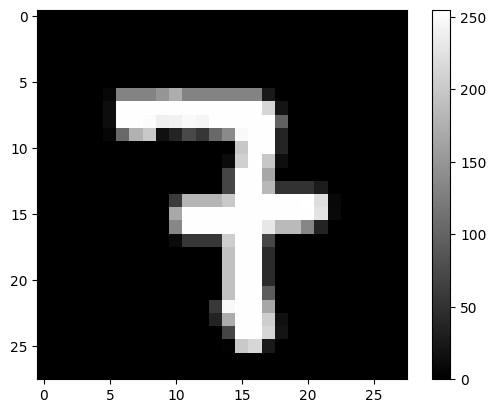

In [8]:
# plot random digit in the training data set
plot_single_digit(data_train[randrange(60000)])

<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


### 4. Extracting features from the digit-images using Histogram of Oriented Digits (HOG)

In [9]:
# Function for extracting HOG features from image data
def extract_HOG_features_from_image_data(input_data):
    df_features = pd.DataFrame()
    data_to_be_transformed = input_data
    for image_index in range(data_to_be_transformed.shape[0]):
        fd, hog_image = hog(data_to_be_transformed[image_index], orientations=8, pixels_per_cell=(4, 4),
                        cells_per_block=(1, 1), channel_axis=-1, visualize=True, )   # channel_axis=-1

        if df_features.shape[0] > 0:
            df_features = pd.concat([df_features, pd.DataFrame(hog_image.ravel().T)], ignore_index=True, axis=1)
        else:
            df_features = pd.DataFrame(hog_image.ravel().T)
            
        if (image_index > 0) and (image_index%10000 < 1):
            print("10000 images processed...")

    return pd.DataFrame(df_features.T)


In [10]:
# Extract (HOG) features from the image data (grab a coffee! This might take a while if you are not on a powerful machine)

#X_train_HOG = extract_HOG_features_from_image_data(data_train)
#X_test_HOG = extract_HOG_features_from_image_data(data_test)

<div style="background-color:rgb(187, 35, 35); padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">

#### TODO: Save The HOG Features as new datafiles

In [11]:
# Saving the HOG features as a new file

#X_train_HOG.to_csv("X_train_HOG.csv", encoding="utf-8", )
#_test_HOG.to_csv("X_test_HOG.csv")

In [12]:
# Re-reading the data in the .csv files into memory

sample_size = 2000

X_train_HOG = pd.read_csv("X_train_HOG.csv")
X_test_HOG = pd.read_csv("X_test_HOG.csv")

X_train_HOG = X_train_HOG[:sample_size]
X_test_HOG = X_test_HOG[:sample_size]

y_train = np.array(labels_train[:sample_size], dtype='i').ravel()
y_test = np.array(labels_test[:sample_size], dtype='i').ravel()

<div style="background-color:rgb(187, 35, 35); padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


#### TODO 3: I have another idea of feature extraction, how about we just compute the mean (and standard deviation) in intensity in X and Y directions?


##### Such that we will have four (two for mean and two for std) additional vectors as features (each with length 28).
##### If you write a function able to compute such features, and use these features in training together with the HOG features,
##### would it lead to better generaliztion (improved accuracy)? Don't forget to normalize these new feature vectors also.

In [13]:
# Support functions
def find_xmean(image_matrix):
    return np.mean(image_matrix, axis=0)

def find_ymean(image_matrix):
    return np.mean(image_matrix, axis=1)

def find_xstd(image_matrix):
    return np.std(image_matrix, axis=0)

def find_ystd(image_matrix):
    return np.std(image_matrix, axis=1)

# Functions to extract the means and standard deviations from each image in the dataset
def extract_new_features(data):
    feature_matrix = []
    for image in data:
        x_mean = find_xmean(image)
        y_mean = find_ymean(image)
        x_std = find_xstd(image)
        y_std = find_ystd(image)
        feature_matrix.append(np.array([x_mean, y_mean, x_std, y_std]).ravel())     # Here we have the 4x28 feature matrix that we flatten to be able to concatenate with the HOG features later
    return np.array(feature_matrix)

# Function calls
train_tmp = extract_new_features(data_train[:sample_size])
test_tmp = extract_new_features(data_test[:sample_size])

# Concatenating the new features with the HOG features and turning them into pandas dataframes for compatability with the noramilization function
X_train_meanstd = pd.DataFrame(np.concatenate((X_train_HOG, train_tmp), axis=1))
X_test_meanstd = pd.DataFrame(np.concatenate((X_test_HOG, test_tmp), axis=1))

<div style="background-color:rgb(29, 112, 50); padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


#### PCA reduction for visualization

Accuracy of the first two plots are: 25.2% and 12.5% respectively.
This variance is way to low for the plot to make any sence, it can not be interpreted as anything since too much imformation is lost during the dimensionality reduction.


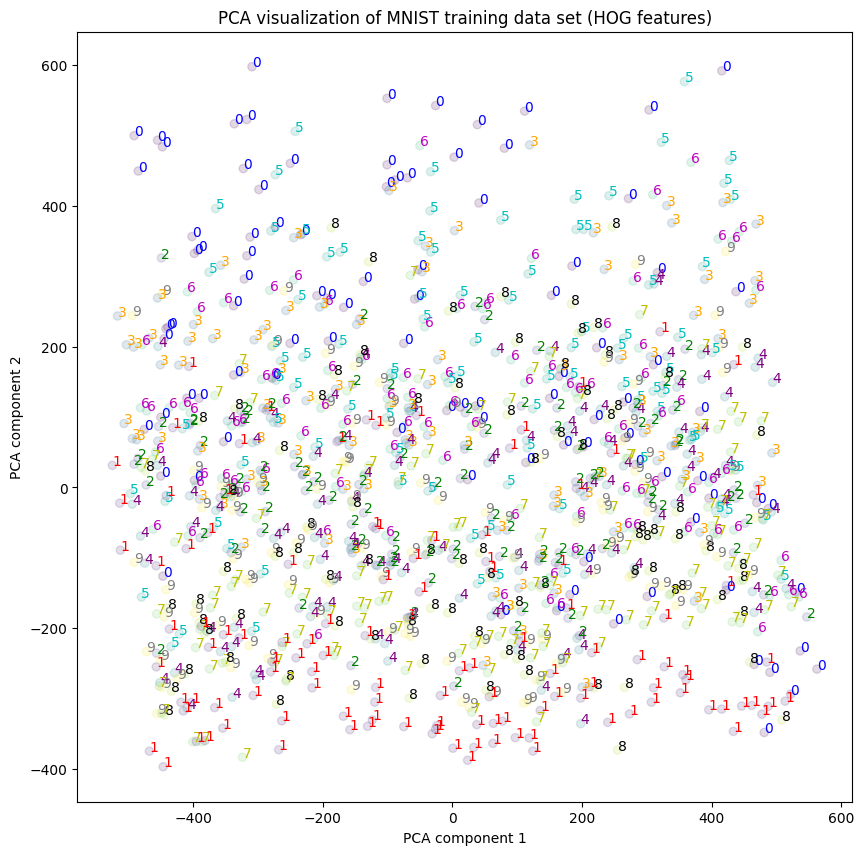

In [34]:
# Visualize (1000 examples of) the extracted features in 2D (reduce the dimensionality of
# the HOG features to 2 by utlizing a method called PCA, will be explained in Module II)

X_for_PCA_viz = X_train_HOG[0:1000]
y_for_PCA_viz = y_train[0:1000]

pca = PCA(n_components=2)
X_r = pca.fit(X_for_PCA_viz).transform(X_for_PCA_viz)
print(f"Accuracy of the first two plots are: {np.round(pca.explained_variance_ratio_[0], 3)*100}% and {np.round(pca.explained_variance_ratio_[1], 3)*100}% respectively.")
print(f"This variance is way to low for the plot to make any sence, it can not be interpreted as anything since too much imformation is lost during the dimensionality reduction.")

plt.figure(figsize=(10, 10))
plt.scatter(X_r[:,0], X_r[:,1], c=y_for_PCA_viz, alpha=0.15)
ax = plt.gca()

colors = {0:'b', 1:'r', 2:'g', 3:'orange', 4:'purple', 5:'c', 6:'m', 7:'y', 8:'k', 9:'gray'}    # To make it easier to see that this plot is useless, we added colors to the numbers and removed the black background.
for i, the_label in enumerate(y_for_PCA_viz):
    ax.annotate(str(the_label), (X_r[i, 0], X_r[i, 1]), color=colors[the_label])

plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.title("PCA visualization of MNIST training data set (HOG features)")
plt.show()

<div style="background-color:rgb(29, 112, 50); padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


#### Data cleaning through: 
 - Removing uninforamtive features
 - Z-score normalization

In [15]:
def remove_uninformative_features(df_input):
    # if a feature contains only one unique value (it is not informative) then remove it!
    cols = df_input.select_dtypes([np.number]).columns
    std = df_input[cols].std()
    cols_to_drop = std[std==0].index
    df_input = df_input.drop(cols_to_drop, axis=1)
    return df_input, cols_to_drop


def normalize_each_feature(df_input):
    return stats.zscore(df_input)

In [16]:
# check to see if we have uninformative features, if so remove them from the training data set (and drop them from the test set also later)
X_train_HOG_with_columns_dropped, columns_that_was_dropped_HOG = remove_uninformative_features(X_train_HOG)

X_train_HOG_normalized = normalize_each_feature(X_train_HOG_with_columns_dropped)
X_test_HOG_normalized = normalize_each_feature(X_test_HOG.drop(columns_that_was_dropped_HOG, axis=1))

X_train_HOG_normalized = X_train_HOG_normalized.to_numpy(dtype=np.float64)
X_test_HOG_normalized = X_test_HOG_normalized.to_numpy(dtype=np.float64)

In [17]:
# Normalizing the meanstd feature matrix the same way as the HOG feature matrix
X_train_meanstd_with_columns_dropped, columns_that_was_dropped_meanstd = remove_uninformative_features(X_train_meanstd)

X_train_meanstd_normalized = normalize_each_feature(X_train_meanstd_with_columns_dropped)
X_test_meanstd_normalized = normalize_each_feature(X_test_meanstd.drop(columns_that_was_dropped_meanstd, axis=1))

X_train_meanstd_normalized = X_train_meanstd_normalized.to_numpy(dtype=np.float64)
X_test_meanstd_normalized = X_test_meanstd_normalized.to_numpy(dtype=np.float64)

<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


### 6.1 + 8.1 + 9.1. Training and evaluating a kNN model with statistics and plots

<div style="background-color:rgb(187, 35, 35); padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


#### TODO 4: Which digit(s) seems to be the most difficult to predict using the k-NN classifier? Could you use the confusion matrix functions: "plot_confusion_matrix" and visualize and draw conclusions and present to me?

Accuracy of the k-NN model (train) is 93.10 percent 
Accuracy of the k-NN model (test) is 83.95 percent


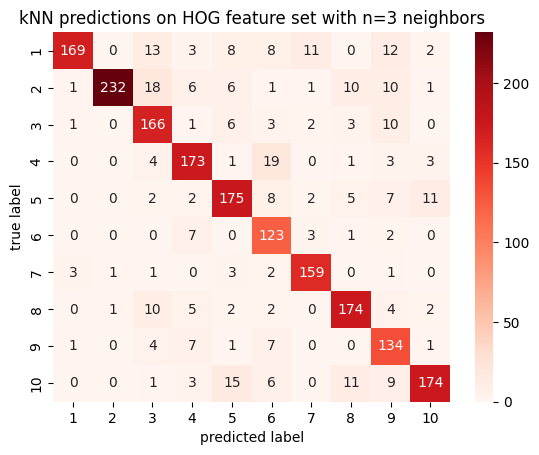

In [18]:
# Train a kNN model on HOG features

kNN_HOG = KNeighborsClassifier(n_neighbors=3)
kNN_HOG.fit(X_train_HOG_normalized, y_train)
print("Accuracy of the k-NN model (train) is %2.2f percent " % float(kNN_HOG.score(X_train_HOG_normalized, y_train)*100.0))
print("Accuracy of the k-NN model (test) is %2.2f percent" % float(kNN_HOG.score(X_test_HOG_normalized, y_test)*100.0))

kNN_predictions_HOG = kNN_HOG.predict(X_test_HOG_normalized)

# We use the seaborn library to make a heatmap instead of using the plot_confusion_matrix, since this function is deprecated in the scikit learn library
kNN_cm_HOG = confusion_matrix(kNN_predictions_HOG, y_test)              
sns.heatmap(kNN_cm_HOG, annot=True, fmt='d', cmap="Reds", xticklabels=range(1,11), yticklabels=range(1,11))
plt.title("kNN predictions on HOG feature set with n=3 neighbors")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()


Accuracy of the k-NN model (train) is 94.15 percent 
Accuracy of the k-NN model (test) is 83.55 percent


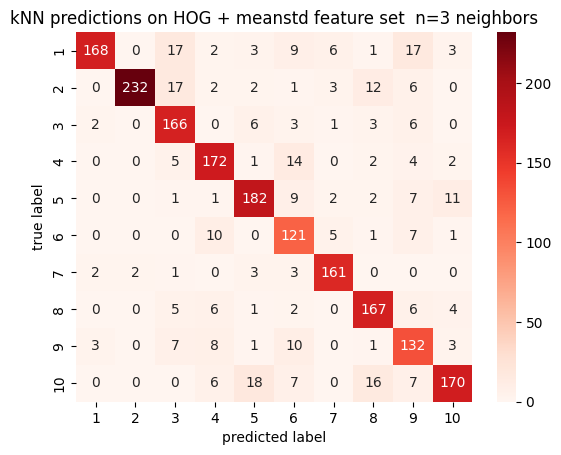

In [19]:
# Train a kNN model on meanstd features

kNN_meanstd = KNeighborsClassifier(n_neighbors=3)
kNN_meanstd.fit(X_train_meanstd_normalized, y_train)
print("Accuracy of the k-NN model (train) is %2.2f percent " % float(kNN_meanstd.score(X_train_meanstd_normalized, y_train)*100.0))
print("Accuracy of the k-NN model (test) is %2.2f percent" % float(kNN_meanstd.score(X_test_meanstd_normalized, y_test)*100.0))

kNN_predictions_meanstd = kNN_meanstd.predict(X_test_meanstd_normalized)

kNN_cm_meanstd = confusion_matrix(kNN_predictions_meanstd, y_test)
sns.heatmap(kNN_cm_meanstd, annot=True, fmt='d', cmap="Reds", xticklabels=range(1,11), yticklabels=range(1,11))
plt.title("kNN predictions on HOG + meanstd feature set  n=3 neighbors")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

<div style="background-color:rgb(187, 35, 35); padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


#### TODO 5: I'm using 3 neighbours for k-NN, how about we use 5 or 7 neighbours? Would this lead to a better generalization performance? Could you test this? (if so, think about training, validation and test set split)

- Evaluate both approaches with k-fold cross validation on the test set

In [20]:
# Using k-fold cross validation on kNN with 5 and 7 neighbors to evaluate how well the model generalizes using the training set.

k=len(X_test_meanstd_normalized)    # using each individual datapoint on their own as validation
k_fold_model = KFold(n_splits=k)

scores_kNN_3 = cross_val_score(KNeighborsClassifier(n_neighbors=3), X_train_meanstd_normalized, y_train, cv=k_fold_model, scoring="accuracy").mean()
scores_kNN_5 = cross_val_score(KNeighborsClassifier(n_neighbors=5), X_train_meanstd_normalized, y_train, cv=k_fold_model, scoring="accuracy").mean()
scores_kNN_7 = cross_val_score(KNeighborsClassifier(n_neighbors=7), X_train_meanstd_normalized, y_train, cv=k_fold_model, scoring="accuracy").mean()

print(f"Average accuracy on kNN model with HOG + meanstd features using k-fold cross validation with {k} folds:")
print(f"    n_neighbors=3 is {np.round(scores_kNN_3*100, 1)}%")
print(f"    n_neighbors=5 is {np.round(scores_kNN_5*100, 1)}%")
print(f"    n_neighbors=7 is {np.round(scores_kNN_7*100, 1)}%\n")
print(f"This shows us that there is no discernable difference between using 3, 5 or 7 nearest neighbors to predict the correct class. ")

Average accuracy on kNN model with HOG + meanstd features using k-fold cross validation with 2000 folds:
    n_neighbors=3 is 88.6%
    n_neighbors=5 is 88.9%
    n_neighbors=7 is 88.7%

This shows us that there is no discernable difference between using 3, 5 or 7 nearest neighbors to predict the correct class. 


<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


### 6.2 + 8.2 + 9.2. Training and evaluating a linear Support Vector Machines model with statistics and plots.

Accuracy of the SMV model (train) is 98.15 percent 
Accuracy of the SMV model (test) is 86.60 percent


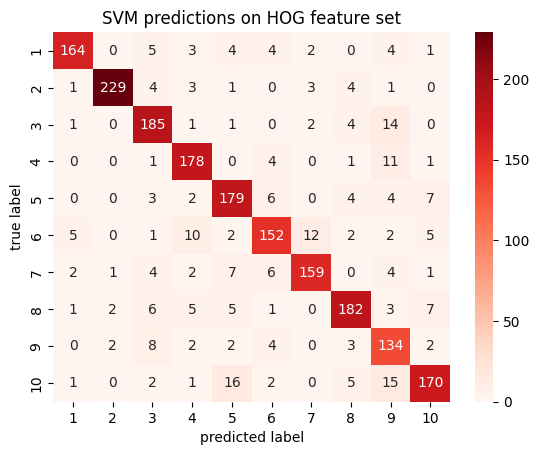

In [21]:
# Train a model using a Linear Support Vector algorithm on HOG feature set

SVM_HOG = LinearSVC(random_state=0, tol=1e-5, max_iter=3000)
SVM_HOG.fit(X_train_HOG_normalized, y_train)

SMV_predictions_HOG = SVM_HOG.predict(X_test_HOG_normalized)

print("Accuracy of the SMV model (train) is %2.2f percent " % float(SVM_HOG.score(X_train_HOG_normalized, y_train)*100.0))
print("Accuracy of the SMV model (test) is %2.2f percent" % float(SVM_HOG.score(X_test_HOG_normalized, y_test)*100.0))

SVM_cm_HOG = confusion_matrix(SMV_predictions_HOG, y_test)             
sns.heatmap(SVM_cm_HOG, annot=True, fmt='d', cmap="Reds", xticklabels=range(1,11), yticklabels=range(1,11))
plt.title("SVM predictions on HOG feature set")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

Accuracy of the SMV model (train) is 100.00 percent 
Accuracy of the SMV model (test) is 87.90 percent



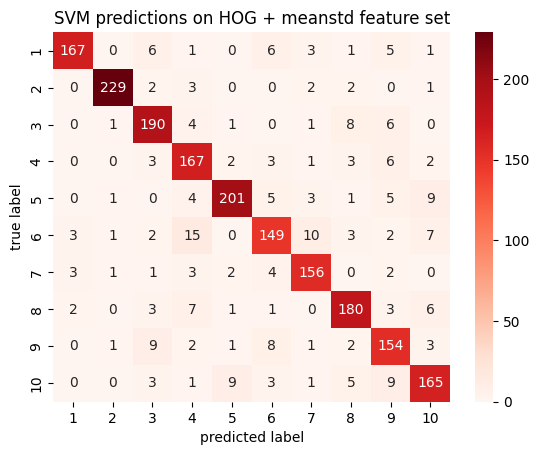

In [ ]:
# Train a model using a Linear Support Vector algorithm on meanstd feature set

SVM_meanstd = LinearSVC(random_state=0, tol=1e-5, max_iter=3000)
SVM_meanstd.fit(X_train_meanstd_normalized, y_train)

SVM_predictions_meanstd = SVM_meanstd.predict(X_test_meanstd_normalized)

print("Accuracy of the SMV model (train) is %2.2f percent " % float(SVM_meanstd.score(X_train_meanstd_normalized, y_train)*100.0))  # This is likely overfitting, but the test data still shows good accuracy
print("Accuracy of the SMV model (test) is %2.2f percent" % float(SVM_meanstd.score(X_test_meanstd_normalized, y_test)*100.0))
print()
SVM_cm_meanstd = confusion_matrix(SVM_predictions_meanstd, y_test)
sns.heatmap(SVM_cm_meanstd, annot=True, fmt='d', cmap="Reds", xticklabels=range(1,11), yticklabels=range(1,11))
plt.title("SVM predictions on HOG + meanstd feature set")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()
